In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../')

from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from model.metrics import psnr, ssim
from model import losses
from model.networks import greyscale_resnet34

In [3]:
from data.load import get_data

# Basic Setup 

In [4]:
gpu_id = 2
num_cores = 4
torch.cuda.set_device(gpu_id)

In [5]:
nb_name = 'featloss-inpainting'
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/')
lr_path = f'EM/training/trainsets/lr/'
hr_path = f'EM/training/trainsets/hr/'
model_path = data_pth/f'EM/models/feat_loss/'
critic_path = data_pth/f'EM/models/critics'

In [6]:
# loading 1st round of data for testing & loading critic
bs_1 = 64
size_1 = 128
db = get_data(data_pth=data_pth, lr_dir=lr_path, hr_dir=hr_path,
             bs=bs_1, in_sz=size_1, out_sz=size_1, max_zoom=6)

In [7]:
xb, yb = db.one_batch()

In [8]:
x, y, z = yb[0]

In [9]:
torch.isclose(z, y).all()

tensor(True)

## Resnet Feature loss

### Load critic model

In [10]:
critic_arch = models.resnet34
wd = 1e-3
superres_metrics = [F.mse_loss, psnr, ssim]
critic = unet_learner(db, critic_arch, wd=wd, 
                         loss_func=losses.mse_loss,
                         metrics=superres_metrics,  
                         blur=False, 
                         norm_type=NormType.Weight, 
                         model_dir=critic_path)
gc.collect()

0

In [11]:
critic.model.load_state_dict(torch.load(critic_path/'critic_patches_state_dict.pkl'))

<All keys matched successfully>

### Define the feature loss function

In [12]:
encoder = critic.model.eval()[0]
feature_maps = losses.find_layers(flatten_model(encoder))
len(feature_maps)

7

In [13]:
feat_loss = losses.FeatureLoss(m_feat=encoder, layer_wgts=[1/7 for _ in range(7)])

# Model

## Initialization

In [14]:
arch = models.resnet34
wd = 1e-3
learn = unet_learner(db, arch, wd=wd, 
                         loss_func=feat_loss,
                         metrics=superres_metrics, 
                         #callback_fns=LossMetrics, 
                         blur=False, 
                         norm_type=NormType.Weight, 
                         model_dir=model_path)
gc.collect()

0

## Load Inpainting Model

In [15]:
learn.model.load_state_dict(torch.load(critic_path/'critic_patches_state_dict.pkl'))

<All keys matched successfully>

In [16]:
learn.freeze()

# Training - progressive resizing

In [17]:
# helper func
lr = 1e-3
def do_fit(save_name, lrs=slice(lr), pct_start=0.9, cycle_len=10):
    learn.fit_one_cycle(cycle_len, lrs, pct_start=pct_start)
    learn.save(save_name)

## size = 128

In [18]:
# loading 3 rounds of data
bs_1 = 64
size_1 = 128
db = get_data(data_pth=data_pth, lr_dir=lr_path, hr_dir=hr_path,
             bs=bs_1, in_sz=size_1, out_sz=size_1, max_zoom=6)

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


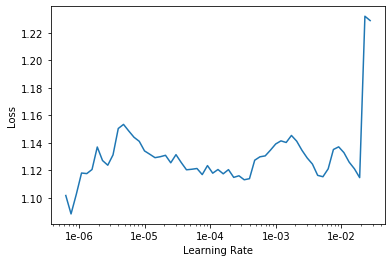

In [20]:
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,mse_loss,psnr,ssim,time
0,0.636508,0.318329,0.042222,22.122208,0.660943,24:22


In [22]:
learn.validate()

[0.31832898, tensor(0.0422), tensor(22.1222), tensor(0.6609)]

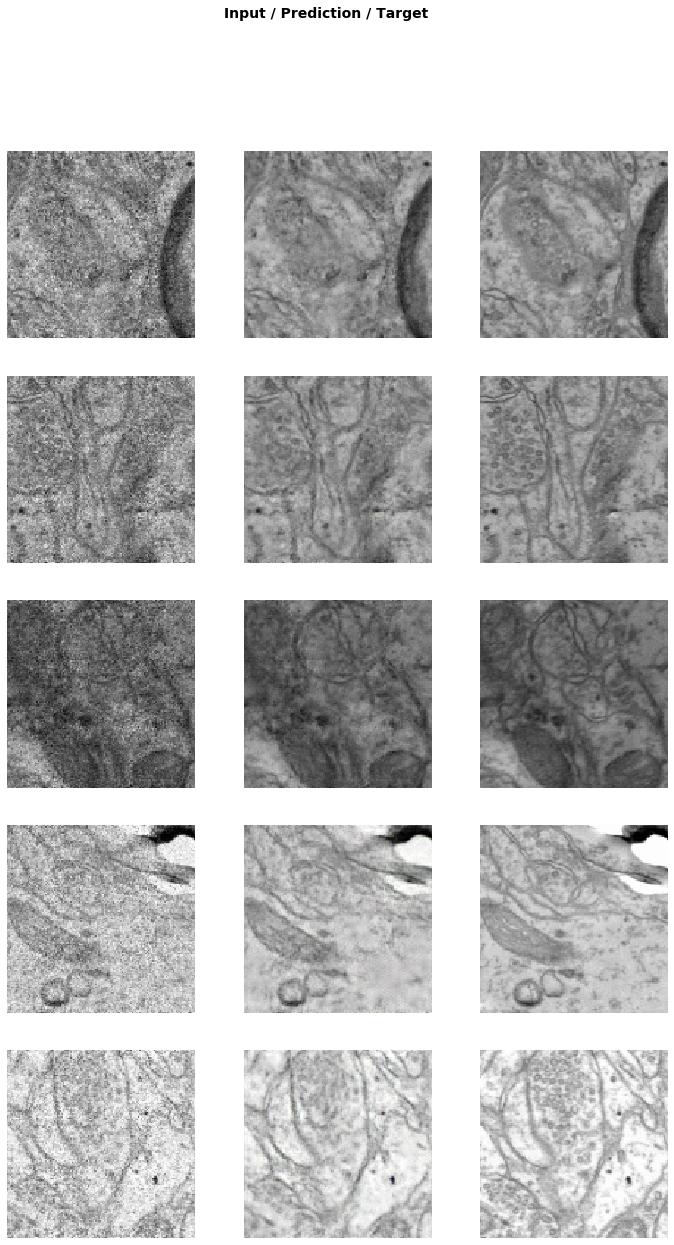

In [23]:
learn.show_results()

In [11]:
bs_2 = 16
size_2 = 256
db = get_data(data_pth=data_pth, lr_dir=lr_path, hr_dir=hr_path,
             bs=bs_2, in_sz=size_2, out_sz=size_2, max_zoom=2.)

In [11]:
bs_1 = 8
size_1 = 512
db = get_data(data_pth=data_pth, lr_dir=lr_path, hr_dir=hr_path,
             bs=bs_1, in_sz=size_1, out_sz=size_1, max_zoom=2.)